In [1]:
import konlpy
import gensim
import sklearn
import seaborn

# 0. WEAT 구현하기

In [2]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [3]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

In [4]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

# 1. 형태소 분석기를 이용하여 품사가 명사인 경우 단어를 추출하기

In [5]:
import os

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

In [6]:
# 약 15분정도 걸립니다.
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

print("슝~")

슝~


In [7]:
print(len(tokenized))

71156


# 2. 추출된 결과로 embedding model 만들기

In [8]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
# model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
# model.most_similar(positive=['영화'])

[('작품', 0.8868610262870789),
 ('다큐멘터리', 0.8457796573638916),
 ('드라마', 0.8272269368171692),
 ('영화로', 0.8094937205314636),
 ('코미디', 0.7825974822044373),
 ('주제', 0.7783645391464233),
 ('형식', 0.7717011570930481),
 ('가족영화', 0.7648875117301941),
 ('감동', 0.7611518502235413),
 ('영상', 0.7611464858055115)]

In [9]:
model.wv.most_similar(positive=['사랑'])

[('첫사랑', 0.7108936905860901),
 ('애정', 0.7105739712715149),
 ('행복', 0.6950017213821411),
 ('진심', 0.6922305226325989),
 ('이별', 0.6896046996116638),
 ('세츠코', 0.6885373592376709),
 ('정일', 0.6836407780647278),
 ('토마슈', 0.6812920570373535),
 ('가슴', 0.6801794767379761),
 ('아르튬', 0.6791903376579285)]

In [10]:
model.wv.most_similar(positive=['연극'])

[('시나리오', 0.8964319229125977),
 ('캐스팅', 0.8867759704589844),
 ('배우', 0.8743441104888916),
 ('팬', 0.8721151351928711),
 ('영화감독', 0.8693058490753174),
 ('공연', 0.8633511662483215),
 ('각색', 0.8615027666091919),
 ('오페라', 0.8598663210868835),
 ('데뷔', 0.8583706021308899),
 ('연기', 0.8582332730293274)]

# 3. target, attribute 단어 셋 만들기

In [11]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

print("슝~")

슝~


In [12]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [13]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [14]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [15]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [16]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
target_overlap = []

for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break
        
# w1과 w2에 모두 존재하는 단어들을 target_overlap에 추가
for i in range(100):
    if (w1_[i] in w2_) and (w1_[i] in model.wv): 
        target_overlap.append(w1_[i])
    if len(target_overlap) == n: break

In [17]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [18]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


In [19]:
print(target_overlap)

['그녀', '자신', '시작', '위해', '사랑', '사람', '영화', '친구', '남자', '가족', '이야기', '마을', '사건', '마음', '세상']


In [20]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [21]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [22]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [23]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while len(attr) < 15 and j < len(w[i]):
        word = vectorizer.get_feature_names()[w[i][j][0]]
        if (word in model.wv) and (word not in target_overlap):
            attr.append(word)
            print(word, end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 지구, 인류, 인간, 미래, 우주, 로봇, 세계, 모든, 박사, 우주선, 외계, 존재, 발견, 행성, 정체, 
가족: 엄마, 아빠, 영화제, 아주르, 아버지, 아들, 국제, 낙타, 할머니, 씨제이, 동구, 아이, 학교, 소년, 슈이트, 
공연: 오페라, 토스카, 실황, 올레, 카바, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 카르피, 비바, 왕자, 콘서트, 
공포(호러): 공포, 발견, 죽음, 악령, 좀비, 사실, 소녀, 하나, 살인, 비밀, 아이, 정체, 저주, 살해, 영화제, 
기타: 영화제, 국제, 서울, 단편, 뉴미디어, 페스티벌, 여자, 대한, 독립, 작품, 엄마, 통해, 아시아나, 다른, 우리, 
다큐멘터리: 영화제, 다큐, 국제, 다큐멘터리, 대한, 감독, 서울, 우리, 세계, 통해, 여성, 한국, 작품, 환경, 사회, 
드라마: 영화제, 국제, 엄마, 여자, 아버지, 단편, 서울, 대한, 아들, 아이, 남편, 서로, 시간, 소녀, 감독, 
멜로로맨스: 남편, 여자, 섹스, 결혼, 서로, 아내, 관계, 부부, 엄마, 아버지, 사실, 점점, 다시, 회사, 시간, 
뮤지컬: 뮤지컬, 에스메랄다, 음악, 충무로, 모차르트, 토스카, 니웨, 카바, 영화제, 바흐, 페뷔스, 프롤, 모도, 카르피, 제루샤, 
미스터리: 발견, 사고, 진실, 죽음, 기억, 살인, 아내, 아이, 민혁, 사실, 의문, 미스터리, 형사, 하나, 비밀, 
범죄: 경찰, 범죄, 조직, 살인, 마약, 형사, 모든, 살해, 수사, 발견, 한길수, 범인, 계획, 은행, 작전, 
사극: 조선, 신기전, 아가멤논, 황제, 루안, 최고, 운명, 하선, 전쟁, 윤서, 트로이, 세자, 허균, 노준, 채선, 
서부극(웨스턴): 서부, 보안관, 벌린, 카우보이, 그레이프바인, 헨리, 개릿, 아이, 무법자, 프린트, 마적, 태구, 현상금, 분노, 버질, 
성인물(에로): 남편, 마사지, 섹스, 관계, 정사, 여자, 유부녀, 에피소드, 그린, 아내, 다시, 자위, 회사, 불륜, 사실, 
스릴

# 4. WEAT score 계산과 시각화

In [24]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
print("슝~")

슝~


In [25]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

print("슝~")

슝~


In [26]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.49694768
SF 공연 -0.106578335
SF 공포(호러) -0.646207
SF 기타 0.29211703
SF 다큐멘터리 0.50526255
SF 드라마 -0.37907842
SF 멜로로맨스 -0.78510845
SF 뮤지컬 0.26722234
SF 미스터리 -0.7237402
SF 범죄 -0.24580473
SF 사극 -0.42434728
SF 서부극(웨스턴) -0.648529
SF 성인물(에로) -0.6073359
SF 스릴러 -0.6413971
SF 애니메이션 0.36373702
SF 액션 -0.54392457
SF 어드벤처 -0.5753993
SF 전쟁 0.1610826
SF 코미디 -0.62802666
SF 판타지 -0.04076455
가족 공연 0.37840912
가족 공포(호러) 0.06570238
가족 기타 0.8254673
가족 다큐멘터리 0.84426916
가족 드라마 0.28616515
가족 멜로로맨스 -0.5815826
가족 뮤지컬 0.8057182
가족 미스터리 -0.22372355
가족 범죄 0.204061
가족 사극 0.27592805
가족 서부극(웨스턴) -0.02069395
가족 성인물(에로) -0.34658962
가족 스릴러 -0.25612023
가족 애니메이션 0.8238617
가족 액션 0.07532401
가족 어드벤처 0.27390072
가족 전쟁 0.59749514
가족 코미디 -0.083196245
가족 판타지 0.6990555
공연 공포(호러) -0.22174041
공연 기타 0.68869865
공연 다큐멘터리 0.76612103
공연 드라마 -0.28168222
공연 멜로로맨스 -0.6042824
공연 뮤지컬 1.0297575
공연 미스터리 -0.3589746
공연 범죄 -0.07824011
공연 사극 -0.2512801
공연 서부극(웨스턴) -0.371298
공연 성인물(에로) -0.509212
공연 스릴러 -0.37640494
공연 애니메이션 0.90967244
공연 액션 -0.2025

<AxesSubplot:>

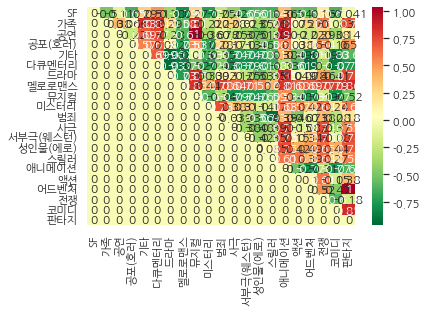

In [27]:
import numpy as np; 
import seaborn as sns; 
import matplotlib as plt

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

| 0.8 이상                     | -0.8 이하                    |
|-----------------------------|------------------------------|
| 공연 - 뮤지컬 (1.0297575)   | 기타 - 드라마 (-0.96334094) |
| 어드벤처 - 판타지 (1.0174631)| 다큐멘터리 - 드라마 (-0.93430877) |
| 멜로로맨스 - 판타지 (0.8558564)| 범죄 - 스릴러 (-0.9322355) |
| 드라마 - 애니메이션 (0.8535587)| 다큐멘터리 - 멜로로맨스 (-0.8723408) |
| 가족 - 다큐멘터리 (0.84426916)| 다큐멘터리 - 코미디 (-0.87073296) |
| 가족 - 뮤지컬 (0.8057182)   | 기타 - 멜로로맨스 (-0.85459507) |
| 가족 - 애니메이션 (0.8238617)| 기타 - 코미디 (-0.8254463) |
| 가족 - 기타 (0.8254673)     |                              |
| 멜로로맨스 - 뮤지컬 (0.8292073)|                              |
| 멜로로맨스 - 애니메이션 (0.8131993)|                          |
| 코미디 - 판타지 (0.8524677) |                              |


- 양수인 경우 예술영화에 가깝고, 음수의 경우 일반영화(상업영화)에 가깝다는 것이다.